In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.efficientnet import EfficientNetB3, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


/Users/sijiehuang/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
csv_path = 'Data/data.csv'
image_folder = 'Data/images/'
img_size = (300, 300)

# Load and filter dataset
df = pd.read_csv(csv_path)
df['full_path'] = df['name'].apply(lambda x: os.path.join(image_folder, x))
df = df[df['full_path'].apply(os.path.exists)].reset_index(drop=True)

In [3]:
df.head()

,Unnamed: 0,bmi,gender,is_training,name,full_path
0,0,34.207396,Male,1,img_0.bmp,Data/images/img_0.bmp
1,1,26.453720,Male,1,img_1.bmp,Data/images/img_1.bmp
2,2,34.967561,Female,1,img_2.bmp,Data/images/img_2.bmp
3,3,22.044766,Female,1,img_3.bmp,Data/images/img_3.bmp
4,6,25.845588,Female,1,img_6.bmp,Data/images/img_6.bmp


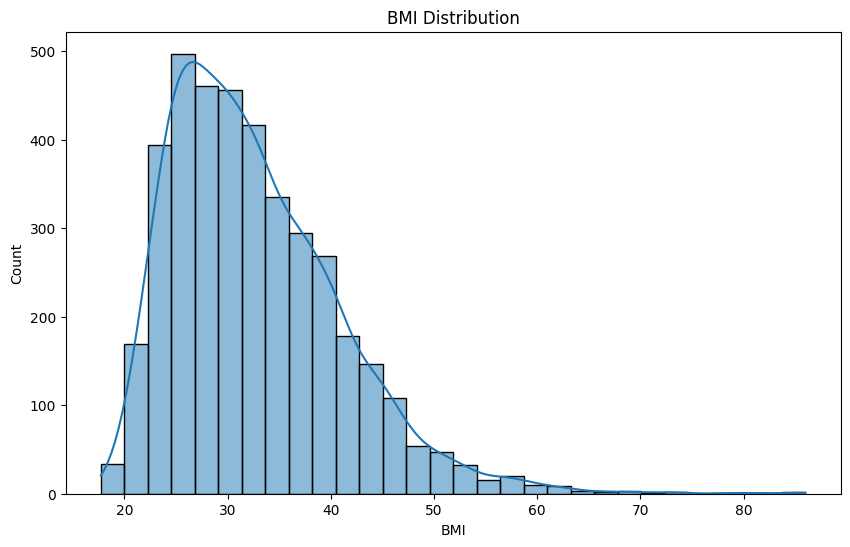

In [4]:
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='bmi', bins=30, kde=True)
plt.title('BMI Distribution')
plt.xlabel('BMI')
plt.ylabel('Count')
plt.show()

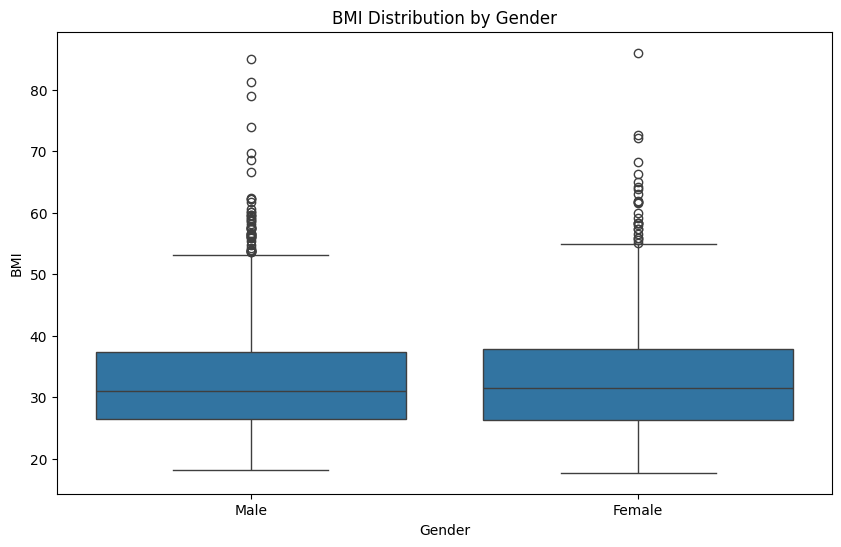

In [5]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='gender', y='bmi')
plt.title('BMI Distribution by Gender')
plt.xlabel('Gender')
plt.ylabel('BMI')
plt.show()

### Data Preprocessing

In [6]:
le = LabelEncoder()
df['gender_encoded'] = le.fit_transform(df['gender'])

In [7]:
def load_and_preprocess(path):
    img = load_img(path, target_size=img_size)
    img = img_to_array(img)
    return preprocess_input(img)

In [8]:
X_img = np.array([load_and_preprocess(p) for p in df['full_path']])
X_gender = df['gender_encoded'].values
y = df['bmi'].values

In [9]:
train_mask = df['is_training'] == 1
X_img_train, X_img_test = X_img[train_mask], X_img[~train_mask]
X_gender_train, X_gender_test = X_gender[train_mask], X_gender[~train_mask]
y_train, y_test = y[train_mask], y[~train_mask]

### Build the model

In [10]:
image_input = Input(shape=(300, 300, 3), name='image_input')
gender_input = Input(shape=(1,), name='gender_input')

base_model = EfficientNetB3(include_top=False, weights='imagenet', input_tensor=image_input)
base_model.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = Concatenate()([x, gender_input])
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, name='bmi_output')(x)

model = Model(inputs=[image_input, gender_input], outputs=output)

model.compile(optimizer=Adam(1e-4), loss='mean_squared_error', metrics=['mae'])

2025-05-15 21:16:27.661454: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2025-05-15 21:16:27.662084: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-05-15 21:16:27.662090: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
I0000 00:00:1747361787.662939 20451431 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1747361787.664372 20451431 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [11]:
early_stop = EarlyStopping(restore_best_weights=True)

history = model.fit(
    [X_img_train, X_gender_train], y_train,
    validation_data=([X_img_test, X_gender_test], y_test),
    epochs=30,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/30


2025-05-15 21:17:20.423725: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


101/101 ━━━━━━━━━━━━━━━━━━━━ 107s 921ms/step - loss: 882.2794 - mae: 28.1882 - val_loss: 367.4240 - val_mae: 16.5614
Epoch 2/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 79s 778ms/step - loss: 229.8904 - mae: 12.3099 - val_loss: 146.5415 - val_mae: 8.7851
Epoch 3/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 89s 878ms/step - loss: 113.2172 - mae: 8.1917 - val_loss: 118.4047 - val_mae: 7.9263
Epoch 4/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 88s 876ms/step - loss: 105.2282 - mae: 8.0152 - val_loss: 111.7481 - val_mae: 7.7247
Epoch 5/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 89s 882ms/step - loss: 101.2260 - mae: 7.7998 - val_loss: 108.6512 - val_mae: 7.6095
Epoch 6/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 89s 887ms/step - loss: 102.5439 - mae: 7.7496 - val_loss: 105.0310 - val_mae: 7.4769
Epoch 7/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 90s 890ms/step - loss: 90.2875 - mae: 7.3787 - val_loss: 101.3408 - val_mae: 7.3569
Epoch 8/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 95s 938ms/step - loss: 88.5215 - mae: 7.3472 - val_loss: 101.0702 - val_mae: 7.3242
Epoch 9/3

24/24 ━━━━━━━━━━━━━━━━━━━━ 26s 800ms/step
Pearson correlation: 0.291
Mean Absolute Error: 6.79


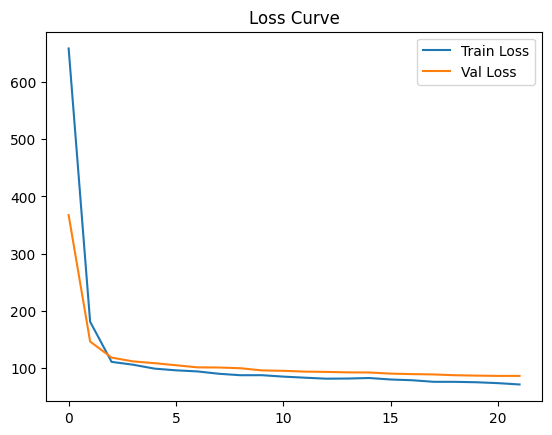

In [12]:
y_pred = model.predict([X_img_test, X_gender_test]).flatten()
pearson_corr, _ = pearsonr(y_test, y_pred)
print(f"Pearson correlation: {pearson_corr:.3f}")

# Optional: MAE
mae = np.mean(np.abs(y_test - y_pred))
print(f"Mean Absolute Error: {mae:.2f}")

# -------------------------------
# 5. Plot Loss Curve
# -------------------------------
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss Curve")
plt.show()

In [13]:
test_df = df[df['is_training'] == 0].copy()
test_df['y_true'] = y_test
test_df['y_pred'] = y_pred

In [14]:
for gender in test_df['gender'].unique():
    subset = test_df[test_df['gender'] == gender]
    r, p = pearsonr(subset['y_true'], subset['y_pred'])
    print(f"{gender}: Pearson r = {r:.3f}, p-value = {p:.4f}")

Male: Pearson r = 0.291, p-value = 0.0000
Female: Pearson r = 0.293, p-value = 0.0000


In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Augmentation config (for training images only)
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# No augmentation for test
test_datagen = ImageDataGenerator()

In [16]:
train_gen = train_datagen.flow(
    X_img_train, y_train,
    batch_size=32, shuffle=True
)

In [17]:
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout, Concatenate, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Inputs
image_input = Input(shape=(300, 300, 3))
gender_input = Input(shape=(1,))

# Base model
base_model = EfficientNetB3(include_top=False, weights='imagenet', input_tensor=image_input)
base_model.trainable = False 

x = GlobalAveragePooling2D()(base_model.output)
x = Concatenate()([x, gender_input])
x = BatchNormalization()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1)(x)

early_stop = EarlyStopping(patience=5, restore_best_weights=True)
lr_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

callbacks = [early_stop, lr_schedule]

In [20]:
model.compile(optimizer=Adam(1e-5), loss='mean_squared_error', metrics=['mae'])

fine_tune_history = model.fit(
    x=[X_img_train, X_gender_train],
    y=y_train,
    validation_data=([X_img_test, X_gender_test], y_test),
    callbacks=callbacks,
    epochs=30,
    batch_size=32
)

Epoch 1/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 116s 951ms/step - loss: 71.6042 - mae: 6.5455 - val_loss: 86.7487 - val_mae: 6.7970 - learning_rate: 1.0000e-05
Epoch 2/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 91s 901ms/step - loss: 73.7761 - mae: 6.6984 - val_loss: 86.6695 - val_mae: 6.7953 - learning_rate: 1.0000e-05
Epoch 3/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 98s 973ms/step - loss: 76.8954 - mae: 6.7820 - val_loss: 86.5546 - val_mae: 6.7910 - learning_rate: 1.0000e-05
Epoch 4/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 95s 941ms/step - loss: 73.8465 - mae: 6.6655 - val_loss: 86.4328 - val_mae: 6.7872 - learning_rate: 1.0000e-05
Epoch 5/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 99s 985ms/step - loss: 74.5924 - mae: 6.6661 - val_loss: 86.6122 - val_mae: 6.7900 - learning_rate: 1.0000e-05
Epoch 6/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 97s 959ms/step - loss: 75.1180 - mae: 6.7369 - val_loss: 86.6706 - val_mae: 6.7905 - learning_rate: 1.0000e-05
Epoch 7/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 783ms/step - loss: 77.2817 - mae: 6.7263
Epoch 7: 

24/24 ━━━━━━━━━━━━━━━━━━━━ 28s 874ms/step
Pearson correlation: 0.295
Mean Absolute Error: 6.78


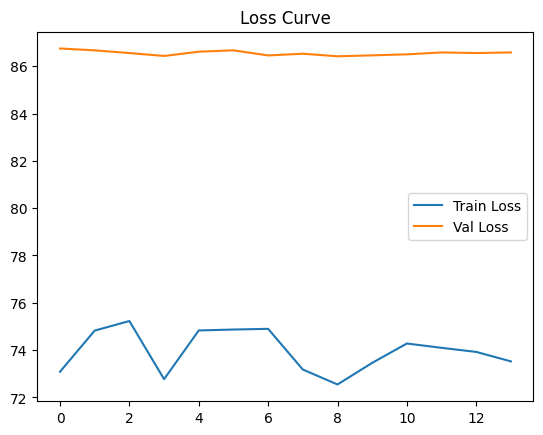

In [21]:
fine_tune_pred = model.predict([X_img_test, X_gender_test]).flatten()
pearson_corr, _ = pearsonr(y_test, fine_tune_pred)
print(f"Pearson correlation: {pearson_corr:.3f}")

# Optional: MAE
mae = np.mean(np.abs(y_test - fine_tune_pred))
print(f"Mean Absolute Error: {mae:.2f}")

# -------------------------------
# 5. Plot Loss Curve
# -------------------------------
plt.plot(fine_tune_history.history['loss'], label='Train Loss')
plt.plot(fine_tune_history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss Curve")
plt.show()

In [22]:
# save the model
model.save('model.h5')